
# Project: Back-End (BE) and Front-End (FE) bug classification

 ## Table of Contents <ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
</ul>

<a id='intro'></a>
## Introduction
> The fact that a bug is a front end (FE) bug or a back end (BE) bug can be helpfull for software production teams. Most of the companies have FE and BE teams, so tagging a bug as an FE or BE bug can help to a better bug assignment. In this work, we try to classify bugs to FE and BE classes. For this purpose, we use **[Eclips platform](https://github.com/logpai/bugrepo/blob/master/EclipsePlatform/eclipse_platform.zip)** data set. These are the steps that we are following to perform this task:
> <ol>
    <li>Undestanding the Data set</li>
    <li>Manually calssifying a limitted sample of the dataset</li>
    <li>Performing some machine learning algorithm on the sample and finding out the accuracy of them</li>
    <li>Asking some developers to classify another sample of dataset (Evaluation set) </li>
    <li>Using the tarined machine learning on the evaluation set </li>
</ol>

<a id='wrangling'></a>
## Data Wrangling

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string

# nltk imports
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

%matplotlib inline


In [3]:
#Reading the dataset from the csv file
df = pd.read_csv('eclipse_platform.csv')

df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time
0,1,P3,Team,NaN,Usability issue with external editors (1GE6IRL),- Setup a project that contains a *.gif resour...,CLOSED,FIXED,2.0,2001-10-10 21:34:00 -0400,2012-02-09 15:57:47 -0500
1,2,P5,Team,NaN,Opening repository resources doesnt honor type...,Opening repository resource always open the de...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2002-05-07 10:33:56 -0400
2,3,P5,Team,NaN,Sync does not indicate deletion (1GIEN83),KM (10/2/2001 5:55:18 PM); \tThis PR about the...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2010-05-07 10:28:53 -0400
3,4,P5,Team,NaN,need better error message if catching up over ...,- become synchronized with some project in a r...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2002-03-01 16:27:31 -0500
4,5,P3,Team,NaN,ISharingManager sharing API inconsistent (1GAU...,For getting/setting the managed state of a res...,RESOLVED,WONTFIX,2.0,2001-10-10 21:34:00 -0400,2008-08-15 08:04:36 -0400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85156 entries, 0 to 85155
Data columns (total 11 columns):
Issue_id            85156 non-null int64
Priority            85156 non-null object
Component           85156 non-null object
Duplicated_issue    14404 non-null float64
Title               85156 non-null object
Description         85027 non-null object
Status              85156 non-null object
Resolution          85156 non-null object
Version             85156 non-null object
Created_time        85156 non-null object
Resolved_time       85156 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 7.1+ MB


In [22]:
# Selecting 1000 bug report to calssify them manually 
df_sample = df.sample(n=1000, random_state=42)

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 10720 to 34367
Data columns (total 11 columns):
Issue_id            1000 non-null int64
Priority            1000 non-null object
Component           1000 non-null object
Duplicated_issue    181 non-null float64
Title               1000 non-null object
Description         998 non-null object
Status              1000 non-null object
Resolution          1000 non-null object
Version             1000 non-null object
Created_time        1000 non-null object
Resolved_time       1000 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 93.8+ KB


In [23]:
# Generate a file name based on time (we don't want to overwrite the file after each run)
filename = ('sample_200_' + str(datetime.datetime.now())+ '.csv').replace(':','_').replace(' ','_')
df_sample.to_csv(filename)

In [25]:
# Selecting 100 bug report as our evaluation set
df_eval = df.sample(100,random_state=42)
df_eval.to_csv('evaluation_set.csv')

In [48]:
# Reading the manually classified file
df_tagged = pd.read_csv('sample_1000.csv', index_col='Issue_id')

In [49]:
df_tagged = df_tagged[~df_tagged['Tag'].isna()]

In [50]:
df_tagged = df_tagged[['Priority','Component','Title','Description','Tag']]

In [57]:
#Adding length of title and description to the data frame. We want to know if there is any relationship between length and tag
df_tagged['Title_len'] = df_tagged['Title'].apply(lambda x : len(x))
df_tagged['Description_len'] = df_tagged['Description'].apply(lambda x : len(x))

In [58]:
df_tagged.head()

,Priority,Component,Title,Description,Tag,Title_len,Description_len
Issue_id,,,,,,,
131003,P3,Text,[javadoc] IDrawingStrategy documentation does ...,The paint method of IDrawingStrategy can be ca...,BE,66,169
56510,P3,UI,[CheatSheets] Cheat Sheet Selection dialog doe...,,FE,67,1
383992,P3,UI,Juno: calling getPartialMatches causes a stack...,calling bindingService.getPartialMatches(trigg...,BE,55,843
56409,P3,Runtime,[other] Core tools need work,In an effort to get the Core tools working aga...,UN,28,647
355228,P3,UI,Modifications to the EModelService.cloneElemen...,1) The clone API should not make any assumptio...,BE,53,621


#### Normalizing texts

><ol>
    <li>Fo analyzing the natural language first we need to remove all the punctuations from sentences.</li>
    <li>Next we need to remove stop words such as and, or, to and... as these words do not have any specific value for us in this context</li>
    <li>Finally, we need to convert all the verbs to its root form. For example, got and get will be converted to get.</li>
</ol>

In [64]:
#this method performs all the three actions listed above

porter = PorterStemmer()
lancaster=LancasterStemmer()
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation] #1. removing punchuation
    nopunc = ''.join(nopunc)
    listOfWords = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] #2. Removing the stop words
    listOfWords2=[];
    for word in listOfWords:
        listOfWords2.append(porter.stem(word)) #3. Converting to the root form
    return listOfWords2

# Example
text_process('it is a test for removing stop words, and converting verbs.')

['test', 'remov', 'stop', 'word', 'convert', 'verb']

## Feature selection:
><ol>
    <li>Title length</li>
    <li>discription length</li>
    <li>Component column</li>
    <li>Title text bag of words (bow)</li>
    <li>Description text bag of words (bow)</li>
    <li>Title text term frequency invers Document frequency (tf-idf)</li>
    <li>Description term frequency invers Document frequency (tf-idf)</li>
</ol>


**1.** Based on the histograms below it seems there is **no coroolation** between *length of the title* and the *tag*

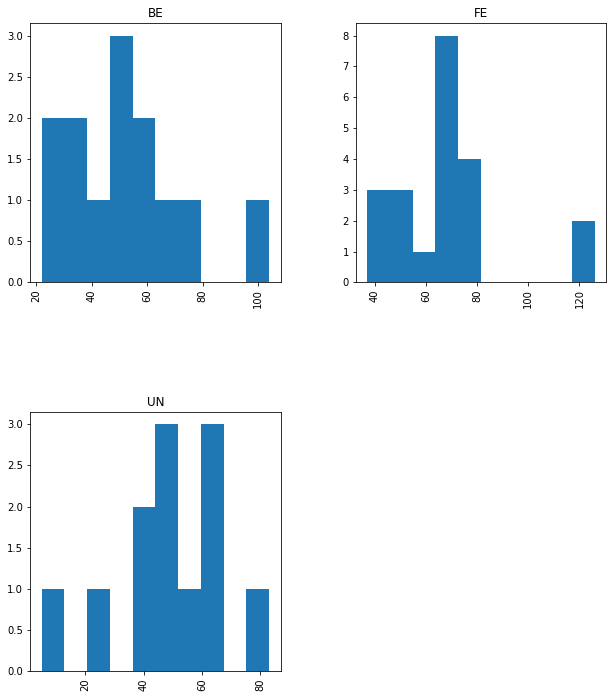

In [65]:
df_tagged.hist(column='Title_len', by ='Tag' ,bins=10, figsize = (10,12));

**1.** Based on the histograms below it seems there is **no coroolation** between *length of the description* and the *tag*

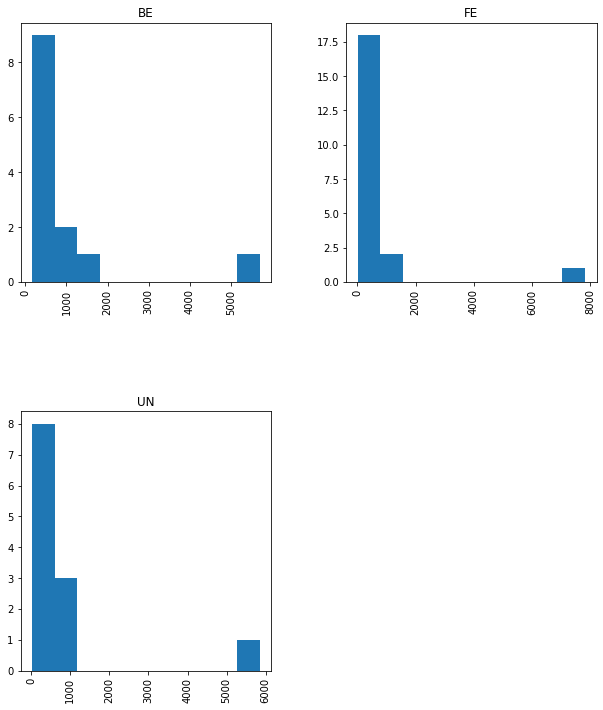

In [66]:
df_tagged.hist(column='Description_len', by ='Tag' ,bins=10, figsize = (10,12));